# Config

In [38]:
import torch
import numpy as np
import mdtraj as md
import nglview as nv


import openmm as mm
import openmm.unit as unit
from openmm import app

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [39]:
state = "c5"
molecule = "alanine"
temperature = "300.0"
version = "timelag-1n-lag30"
dataset_dir = f"../dataset/{molecule}/{temperature}/{version}/"


PHI_ANGLE = [4, 6, 8, 14]
PSI_ANGLE = [6, 8, 14, 16]
ALANINE_HEAVY_ATOM_IDX = [1, 4, 5, 6, 8, 10, 14, 15, 16, 18]

# Basic plot check

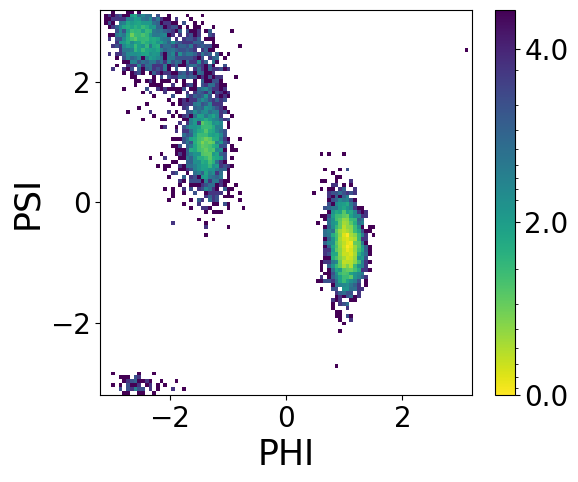

In [40]:
phi = np.load(f"{dataset_dir}/phi.npy")
psi = np.load(f"{dataset_dir}/psi.npy")

fig, ax = plt.subplots(figsize=(6, 5))
plot_range = [-3.2, 3.2]
h, x_bins, y_bins, im = ax.hist2d(phi, psi, 100, norm=LogNorm(), range=[plot_range,plot_range],rasterized=True)
ticks = np.array([np.exp(-6)*h.max(), np.exp(-4.0)*h.max(),np.exp(-2)*h.max(), h.max()])
ax.set_xlabel("PHI", fontsize=25)
ax.set_ylabel("PSI", fontsize=25)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
cbar = fig.colorbar(im, ticks=ticks)
cbar.ax.set_yticklabels([6.0,4.0,2.0,0.0], fontsize=20)
cbar.ax.invert_yaxis()

# Energy computation

In [63]:
data = torch.load(f"{dataset_dir}xyz-aligned-timelag.pt")
data.shape

torch.Size([10000, 22, 3])

In [64]:
def init_simulation():
    pdb = PDBFile(f"../data/alanine/c5.pdb")
    forcefield = app.ForceField("amber99sbildn.xml", "tip3p.xml")
    system = forcefield.createSystem(
		pdb.topology,
		nonbondedMethod=app.PME,
		constraints=app.HBonds,
		ewaldErrorTolerance=0.0005,
	)
    integrator = LangevinIntegrator(
        300.0 * unit.kelvin,
        0.001 / unit.femtoseconds,
        1 * unit.femtoseconds
    )
    platform = mm.Platform.getPlatformByName("OpenCL")
    properties = {'DeviceIndex': '0', 'Precision': "mixed"}

    simulation = Simulation(
        pdb.topology,
        system,
        integrator,
        platform,
        properties
    )        
    simulation.context.setPositions(pdb.positions)   
    simulation.minimizeEnergy()
    
    return simulation

def set_simulation(simulation, frame):
    if frame is not None:
        atom_xyz = frame.detach().cpu().numpy()
        atom_list = [Vec3(atom[0], atom[1], atom[2]) for atom in atom_xyz]
        current_state_openmm = unit.Quantity(value=atom_list, unit=unit.nanometer)
        simulation.context.setPositions(current_state_openmm)
    else:
        raise ValueError("Frame is None")
    
    simulation.context.setVelocities(unit.Quantity(value=np.zeros(frame.shape), unit=unit.nanometer/unit.picosecond))
    
    return simulation

In [65]:
def potential_energy(trajectory):
	simulation = init_simulation()
	energy_list = []

	for frame in tqdm(
		trajectory,
		desc="Calculating potential energy",
	):
		simulation = set_simulation(simulation, frame)
		energy = simulation.context.getState(getEnergy=True).getPotentialEnergy()
		energy_list.append(energy._value)

	return np.array(energy_list)

In [66]:
dataset_energy = potential_energy(data)
print(dataset_energy.shape)

Calculating potential energy:   0%|          | 0/10000 [00:00<?, ?it/s]

(10000,)


In [67]:
file_name = f"{dataset_dir}energy-timelag.npy"
np.save(file_name, dataset_energy)
print(f"Energy saved at {file_name}")

Energy saved at ../dataset/alanine/300.0/timelag-1n-lag30/energy-timelag.npy


Text(0.5, 1.0, 'Energy distribution')

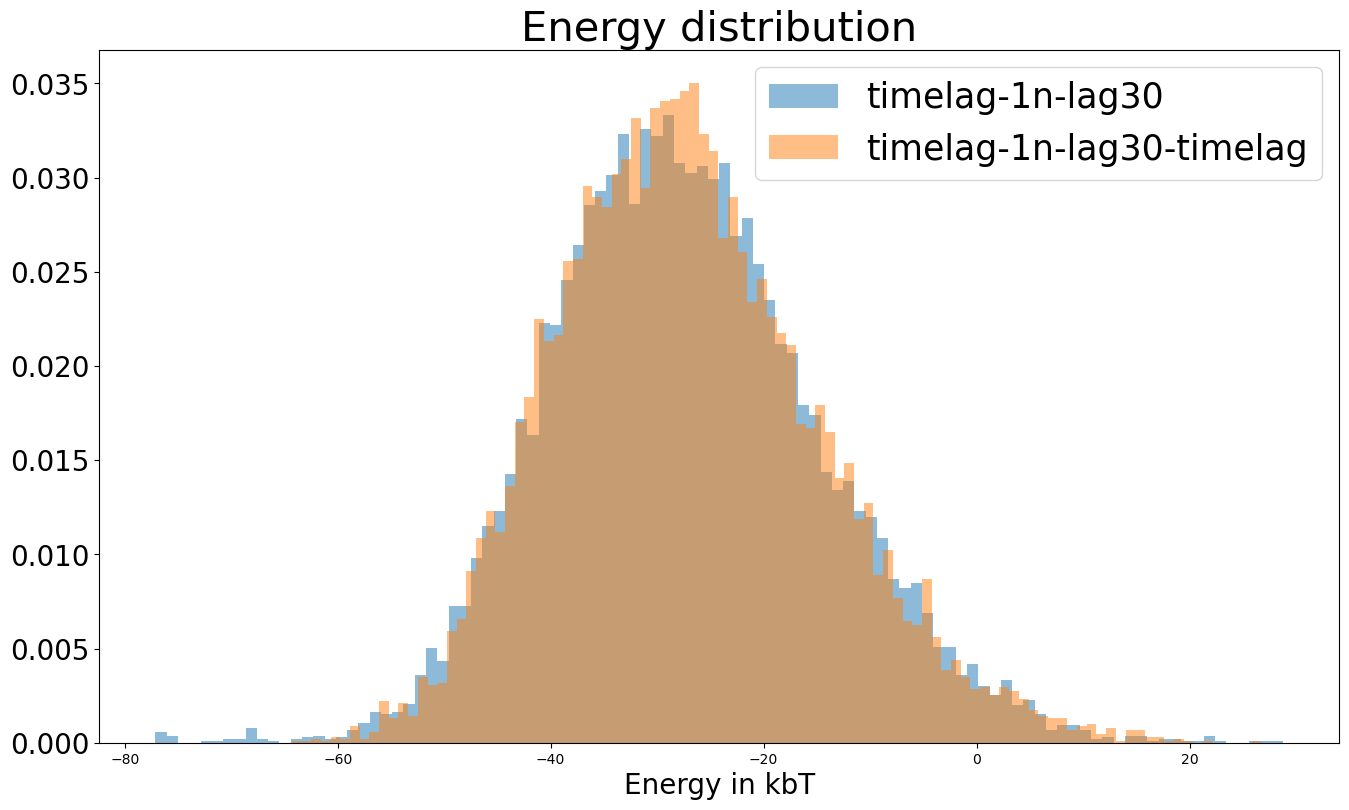

In [68]:
current_energy = np.load(f"{dataset_dir}energy.npy")
timelag_energy = np.load(f"{dataset_dir}energy-timelag.npy")

plt.figure(figsize=(16,9))
plt.hist(current_energy, bins=100, alpha=0.5, density=True, label=f"{version}");
plt.hist(timelag_energy, bins=100, alpha=0.5, density=True, label=f"{version}-timelag");

plt.legend(fontsize=25)
plt.xlabel("Energy in kbT", fontsize=20)  
plt.yticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Energy distribution", fontsize=30)